In [2]:
# SKLearn Implemention
from sklearn.metrics import log_loss
log_loss(["REAL", "FAKE", "FAKE", "REAL"],
         [[.1, .9], [.9, .1], [.8, .2], [.35, .65]])

0.21616187468057912

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2 as cv
import os
import keras
from IPython.display import Video
from IPython.display import HTML
from PIL import Image, ImageDraw
import face_recognition
from tqdm.notebook import tqdm
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from scipy import ndimage, misc
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [4]:
DATA_FOLDER = '/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos/'
TEST_FOLDER = 'test_videos'
train_sample_metadata = pd.read_json('/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data/train_sample_videos/metadata.json').T
train_sample_metadata.head()

label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

In [5]:
train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))
test_list = list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


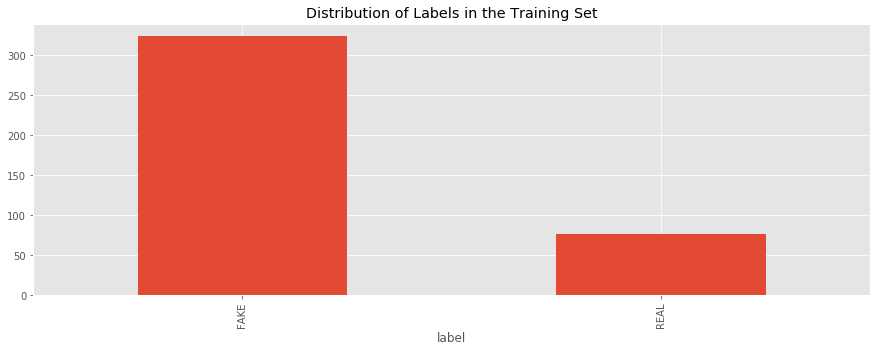

In [6]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

### use the face_recognition package to detect faces in the video

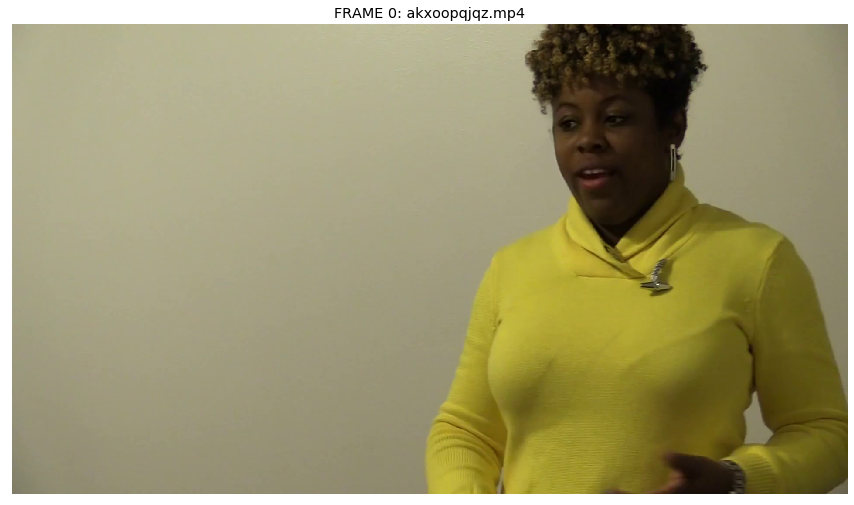

In [7]:
train_dir = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)
fig, ax = plt.subplots(1,1, figsize=(15, 15))
train_video_files = [train_dir + x for x in os.listdir(train_dir)]
# video_file = train_video_files[30]
video_file = train_dir + 'akxoopqjqz.mp4'
cap = cv.VideoCapture(video_file)
success, image = cap.read()
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release()   
ax.imshow(image)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
plt.grid(False)

### Locating a face within an image

The chin in this face has the following points: [(1247, 239), (1245, 268), (1247, 297), (1255, 328), (1268, 358), (1285, 387), (1304, 416), (1323, 438), (1350, 445), (1383, 439), (1419, 423), (1453, 399), (1482, 370), (1501, 335), (1507, 295), (1505, 256), (1501, 219)]
The left_eyebrow in this face has the following points: [(1251, 198), (1257, 185), (1272, 181), (1288, 183), (1304, 190)]
The right_eyebrow in this face has the following points: [(1342, 184), (1362, 171), (1386, 165), (1411, 170), (1432, 181)]
The nose_bridge in this face has the following points: [(1324, 219), (1323, 235), (1320, 250), (1319, 267)]
The nose_tip in this face has the following points: [(1301, 294), (1313, 298), (1327, 299), (1343, 296), (1358, 293)]
The left_eye in this face has the following points: [(1264, 234), (1273, 227), (1287, 226), (1303, 230), (1289, 235), (1275, 237)]
The right_eye in this face has the following points: [(1365, 224), (1378, 215), (1394, 215), (1410, 219), (1395, 224), (1379, 22

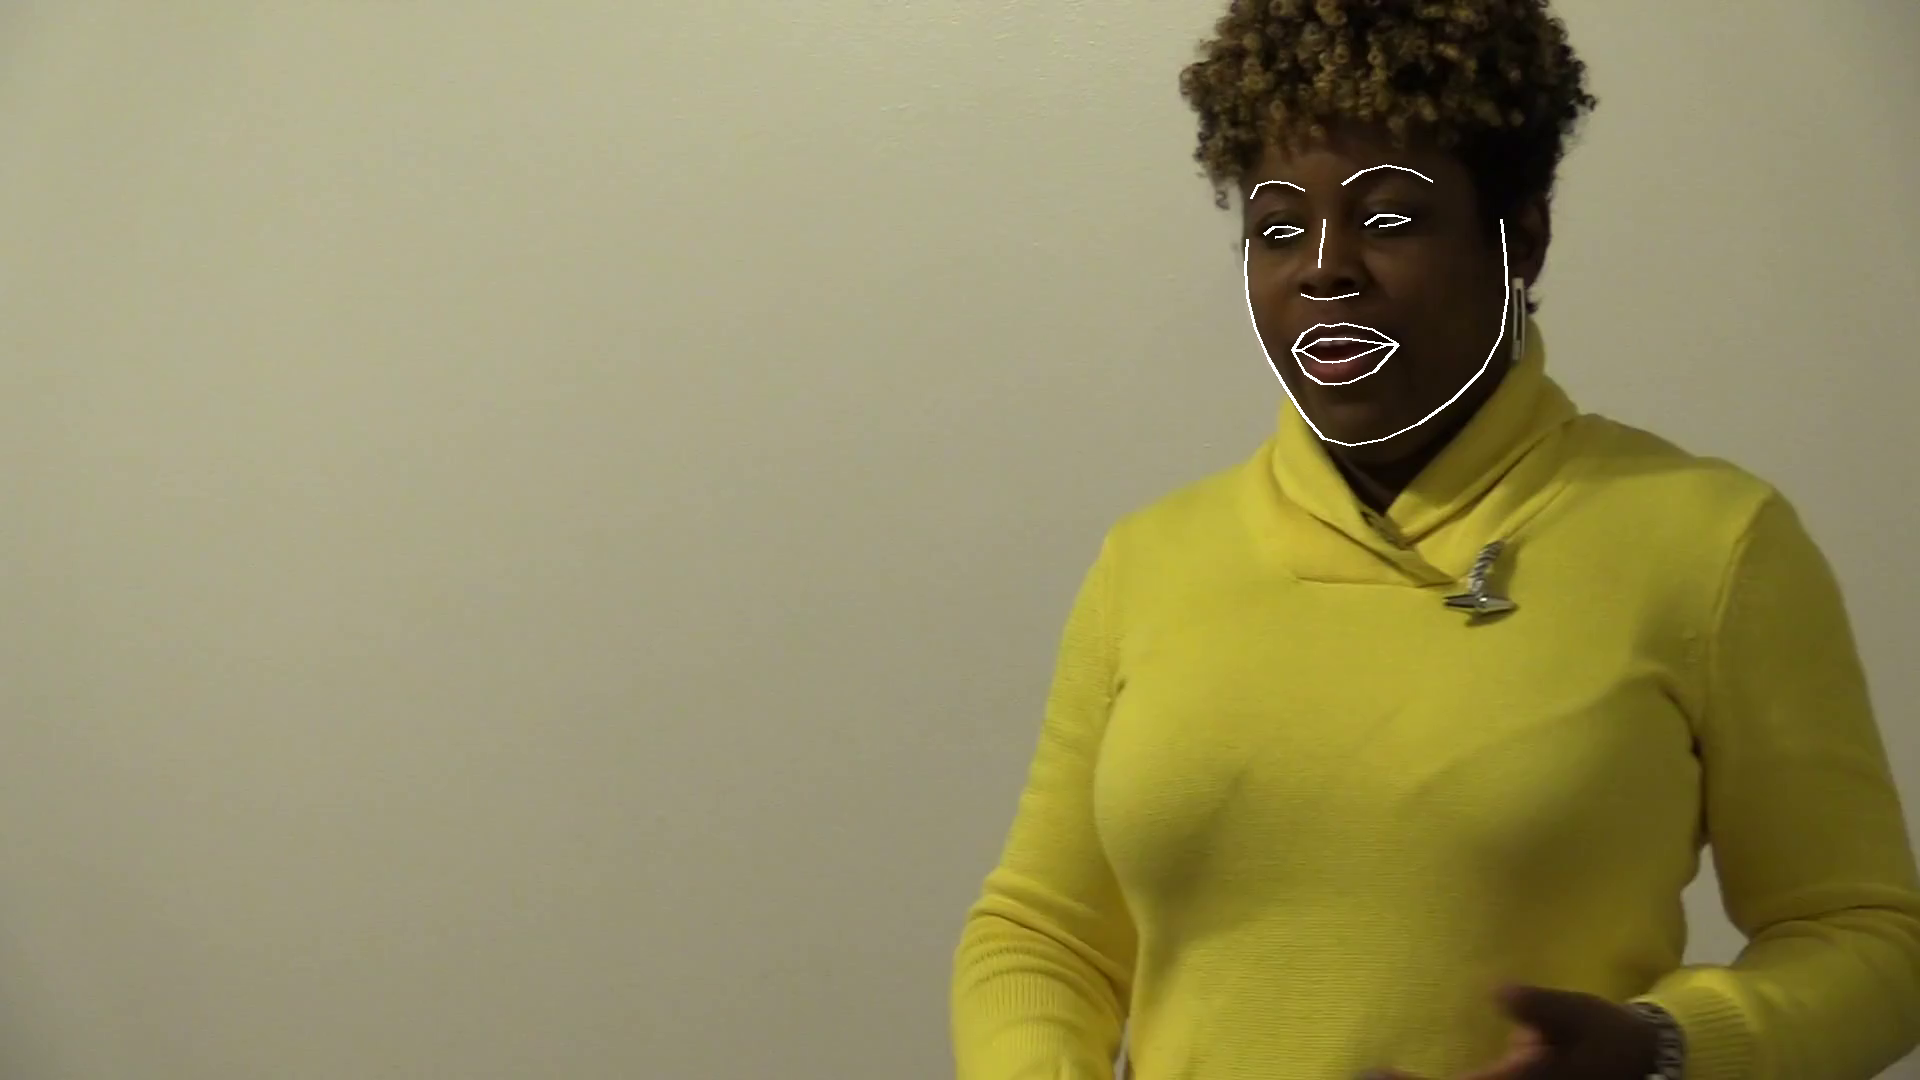

In [8]:
face_landmarks_list = face_recognition.face_landmarks(image)
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)
for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

### Displaying many test examples and labels

[[[197 212 201]
  [197 212 201]
  [197 212 201]
  ...
  [184 212 203]
  [184 212 203]
  [184 212 203]]

 [[197 212 201]
  [197 212 201]
  [197 212 201]
  ...
  [184 212 203]
  [184 212 203]
  [184 212 203]]

 [[197 212 201]
  [197 212 201]
  [197 212 201]
  ...
  [184 212 203]
  [184 212 203]
  [184 212 203]]

 ...

 [[211 214 191]
  [211 214 191]
  [211 214 191]
  ...
  [237 229 210]
  [238 229 208]
  [238 229 208]]

 [[211 214 191]
  [211 214 191]
  [211 214 191]
  ...
  [237 229 210]
  [238 229 208]
  [238 229 208]]

 [[211 214 191]
  [211 214 191]
  [211 214 191]
  ...
  [237 229 210]
  [238 229 208]
  [238 229 208]]]
[[[ 14  18  20]
  [ 14  18  20]
  [ 14  18  20]
  ...
  [101 126 127]
  [101 126 127]
  [101 126 127]]

 [[ 14  18  20]
  [ 14  18  20]
  [ 14  18  20]
  ...
  [101 126 127]
  [101 126 127]
  [101 126 127]]

 [[ 14  18  20]
  [ 14  18  20]
  [ 14  18  20]
  ...
  [101 126 127]
  [101 126 127]
  [101 126 127]]

 ...

 [[ 10  18  22]
  [  9  17  21]
  [  9  17  21]
  ..

[[[128 148 163]
  [128 148 163]
  [128 148 163]
  ...
  [125 139 158]
  [125 139 158]
  [125 139 158]]

 [[128 148 163]
  [128 148 163]
  [128 148 163]
  ...
  [125 139 158]
  [125 139 158]
  [125 139 158]]

 [[128 148 163]
  [128 148 163]
  [128 148 163]
  ...
  [125 139 158]
  [125 139 158]
  [125 139 158]]

 ...

 [[ 41  48  54]
  [ 41  48  54]
  [ 41  48  54]
  ...
  [246 254 253]
  [246 254 253]
  [246 254 253]]

 [[ 41  48  54]
  [ 41  48  54]
  [ 41  48  54]
  ...
  [246 254 253]
  [246 254 253]
  [246 254 253]]

 [[ 42  49  55]
  [ 42  49  55]
  [ 42  49  55]
  ...
  [246 254 253]
  [246 254 253]
  [246 254 253]]]
[[[203 223 252]
  [203 223 252]
  [204 224 253]
  ...
  [148 158 113]
  [148 158 113]
  [148 158 113]]

 [[203 223 252]
  [203 223 252]
  [204 224 253]
  ...
  [148 158 113]
  [148 158 113]
  [148 158 113]]

 [[203 223 252]
  [203 223 252]
  [204 224 253]
  ...
  [148 158 113]
  [148 158 113]
  [148 158 113]]

 ...

 [[240 249 255]
  [240 249 255]
  [240 249 255]
  ..

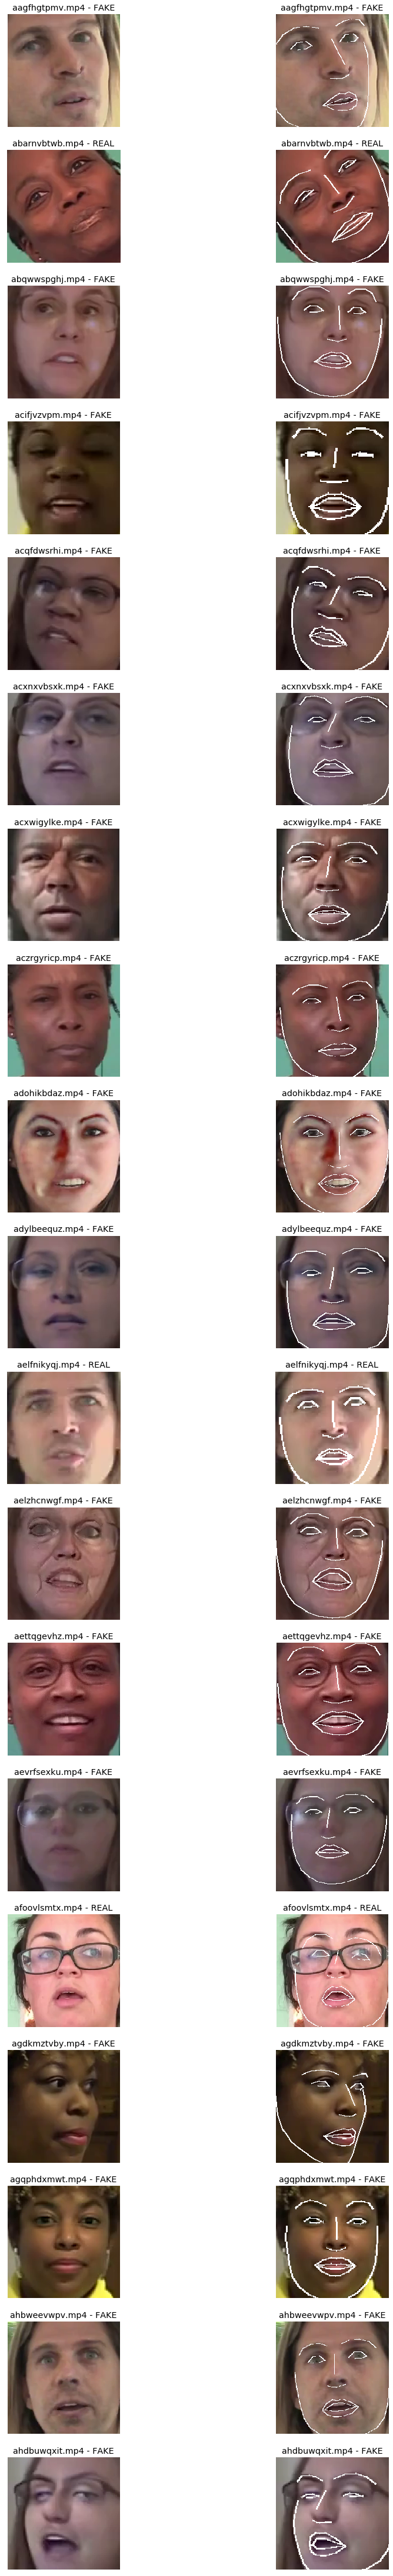

In [9]:
fig, axs = plt.subplots(19, 2, figsize=(15, 80))
axs = np.array(axs)
axs = axs.reshape(-1)
i = 0
for fn in train_sample_metadata.index[:23]:
    label = train_sample_metadata.loc[fn]['label']
    orig = train_sample_metadata.loc[fn]['label']
    video_file = f'/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data/train_sample_videos/{fn}'
    ax = axs[i]
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    print(image)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) > 0:
        # Print first face
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        ax.imshow(face_image)
        ax.grid(False)
        ax.title.set_text(f'{fn} - {label}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Find landmarks
        face_landmarks_list = face_recognition.face_landmarks(face_image)
        face_landmarks = face_landmarks_list[0]
        pil_image = Image.fromarray(face_image)
        d = ImageDraw.Draw(pil_image)
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], width=2)
        landmark_face_array = np.array(pil_image)
        ax2 = axs[i+1]
        ax2.imshow(landmark_face_array)
        ax2.grid(False)
        ax2.title.set_text(f'{fn} - {label}')
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        i += 2
plt.grid(False)
plt.show()

### Add padding to zoom out of face

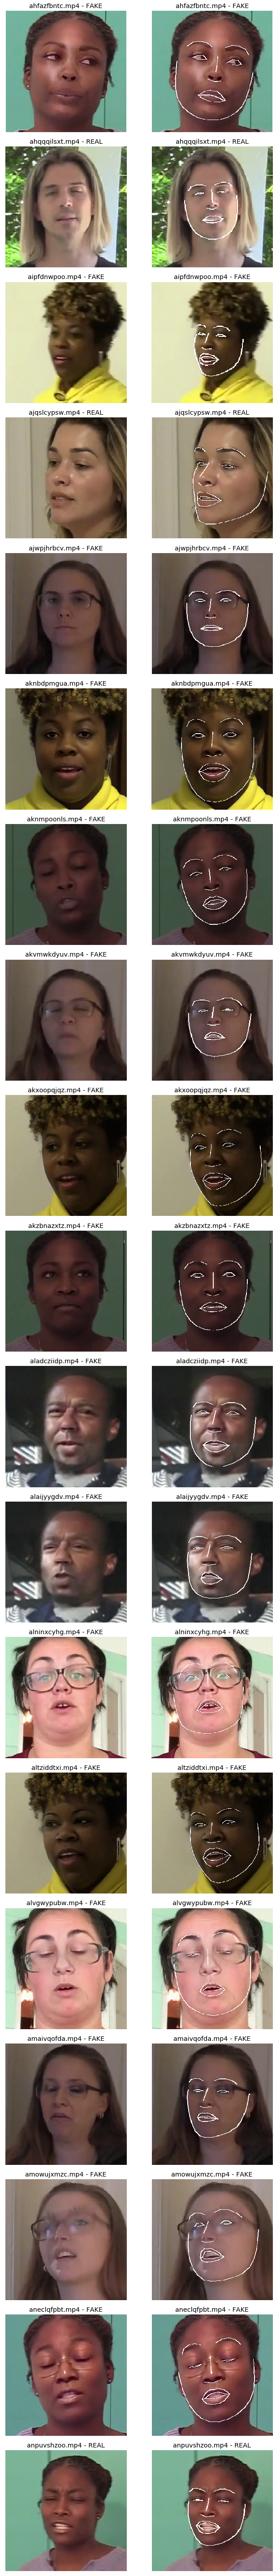

In [10]:
fig, axs = plt.subplots(19, 2, figsize=(10, 80))
axs = np.array(axs)
axs = axs.reshape(-1)
i = 0
pad = 60
for fn in train_sample_metadata.index[23:44]:
    label = train_sample_metadata.loc[fn]['label']
    orig = train_sample_metadata.loc[fn]['label']
    video_file = f'/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data/train_sample_videos/{fn}'
    ax = axs[i]
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) > 0:
        # Print first face
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top-pad:bottom+pad, left-pad:right+pad]
        ax.imshow(face_image)
        ax.grid(False)
        ax.title.set_text(f'{fn} - {label}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Find landmarks
        face_landmarks_list = face_recognition.face_landmarks(face_image)
        try:
            face_landmarks = face_landmarks_list[0]
            pil_image = Image.fromarray(face_image)
            d = ImageDraw.Draw(pil_image)
            for facial_feature in face_landmarks.keys():
                d.line(face_landmarks[facial_feature], width=2, fill='white')
            landmark_face_array = np.array(pil_image)
            ax2 = axs[i+1]
            ax2.imshow(landmark_face_array)
            ax2.grid(False)
            ax2.title.set_text(f'{fn} - {label}')
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            i += 2
        except:
            pass
plt.grid(False)
plt.tight_layout()
plt.show()

### Frame by Frame Face Detection

In [11]:
# take akxoopqjqz.mp4 as an example

In [12]:
video_file = '/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data/train_sample_videos/akxoopqjqz.mp4'

cap = cv.VideoCapture(video_file)

frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frames.append(frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()

print('The number of frames saved: ', len(frames))

The number of frames saved:  300


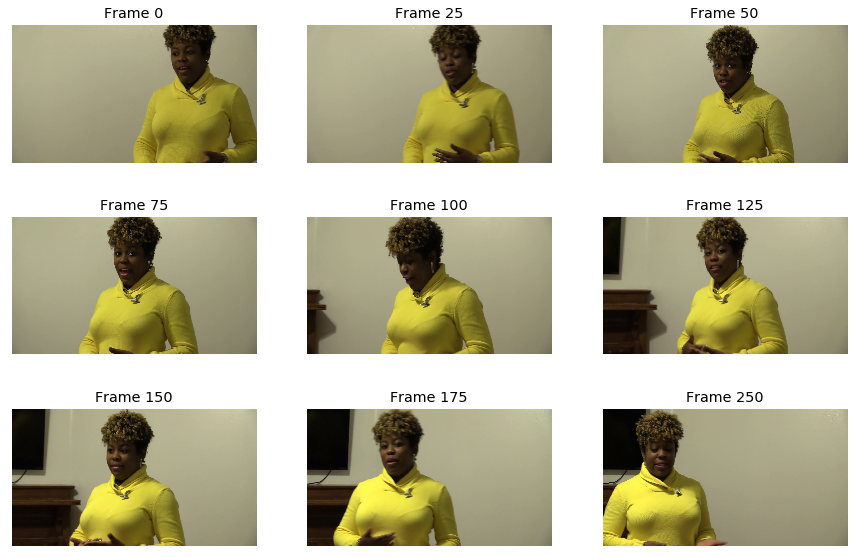

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = np.array(axes)
axes = axes.reshape(-1)

ax_ix = 0
for i in [0, 25, 50, 75, 100, 125, 150, 175, 250]:
    frame = frames[i]
    #fig, ax = plt.subplots(1,1, figsize=(5, 5))
    image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    axes[ax_ix].imshow(image)
    axes[ax_ix].xaxis.set_visible(False)
    axes[ax_ix].yaxis.set_visible(False)
    axes[ax_ix].set_title(f'Frame {i}')
    ax_ix += 1
plt.grid(False)
plt.show()

Could not find face in frame 100


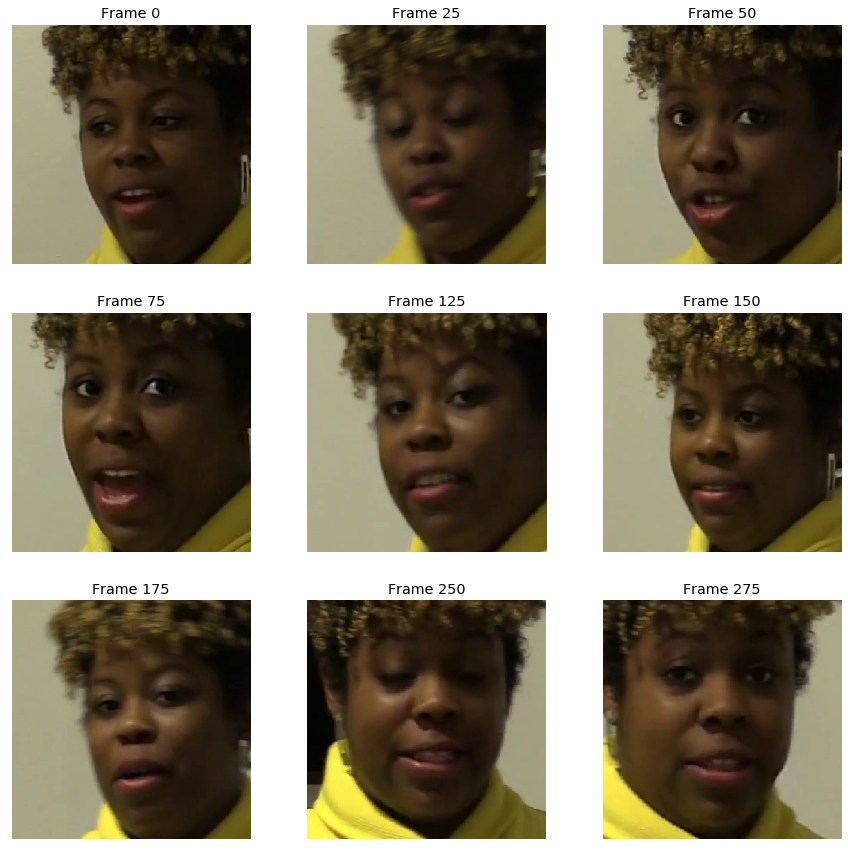

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = np.array(axes)
axes = axes.reshape(-1)
ax_ix = 0
padding = 40
for i in [0, 25, 50, 75, 100, 125, 150, 175, 250, 275]:
    frame = frames[i]
    #fig, ax = plt.subplots(1,1, figsize=(5, 5))
    face_locations = face_recognition.face_locations(frame)
    if len(face_locations) == 0:
        print(f'Could not find face in frame {i}')
        continue
    top, right, bottom, left = face_locations[0]
    frame_face = frame[top-padding:bottom+padding, left-padding:right+padding]
    image = cv.cvtColor(frame_face, cv.COLOR_BGR2RGB)
    axes[ax_ix].imshow(image)
    axes[ax_ix].xaxis.set_visible(False)
    axes[ax_ix].yaxis.set_visible(False)
    axes[ax_ix].set_title(f'Frame {i}')
    ax_ix += 1
plt.grid(False)
plt.show()

### Plotting facial landmarks for each frame

Count find face in frame 100


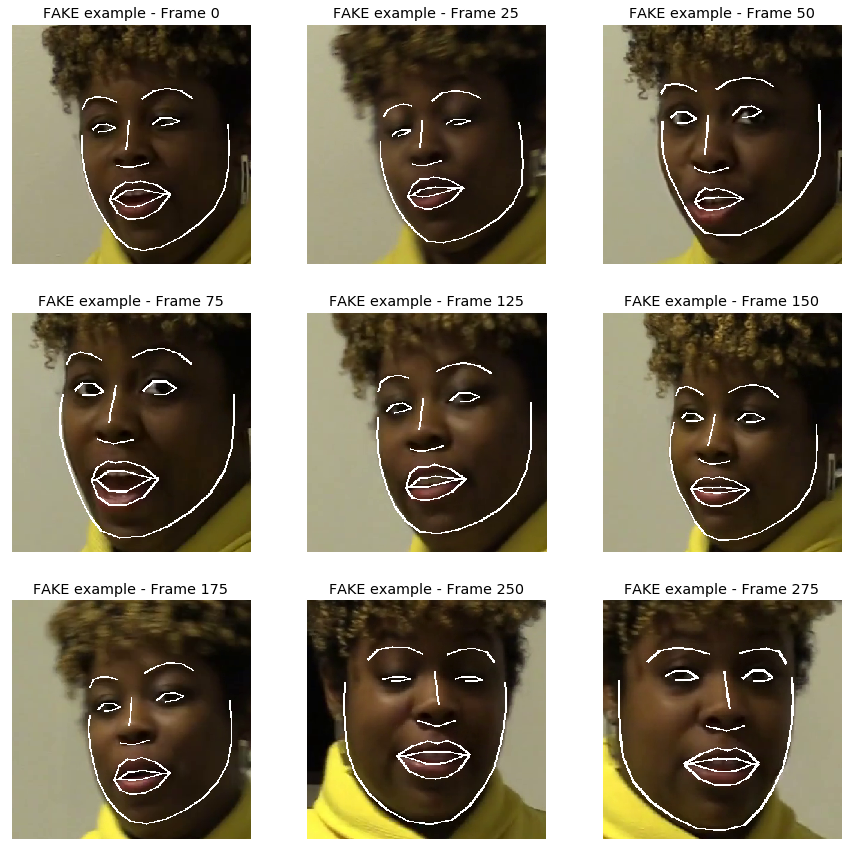

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = np.array(axes)
axes = axes.reshape(-1)
ax_ix = 0
padding = 40
for i in [0, 25, 50, 75, 100, 125, 150, 175, 250, 275]:
    frame = frames[i]
    #fig, ax = plt.subplots(1,1, figsize=(5, 5))
    face_locations = face_recognition.face_locations(frame)
    if len(face_locations) == 0:
        print(f'Count find face in frame {i}')
        continue
    top, right, bottom, left = face_locations[0]
    frame_face = frame[top-padding:bottom+padding, left-padding:right+padding]
    face_landmarks_list = face_recognition.face_landmarks(frame_face)
    if len(face_landmarks_list) == 0:
        print(f'Could not identify face landmarks for frame {i}')
        continue
    face_landmarks = face_landmarks_list[0]
    pil_image = Image.fromarray(frame_face)
    d = ImageDraw.Draw(pil_image)
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3, fill='white')
    landmark_face_array = np.array(pil_image)
    image = cv.cvtColor(landmark_face_array, cv.COLOR_BGR2RGB)
    axes[ax_ix].imshow(image)
    axes[ax_ix].grid(False)
    axes[ax_ix].set_title(f'FAKE example - Frame {i}')
    axes[ax_ix].xaxis.set_visible(False)
    axes[ax_ix].yaxis.set_visible(False)
    ax_ix += 1
plt.grid(False)
plt.show()

### Frame by frame of REAL example

The number of frames saved:  300


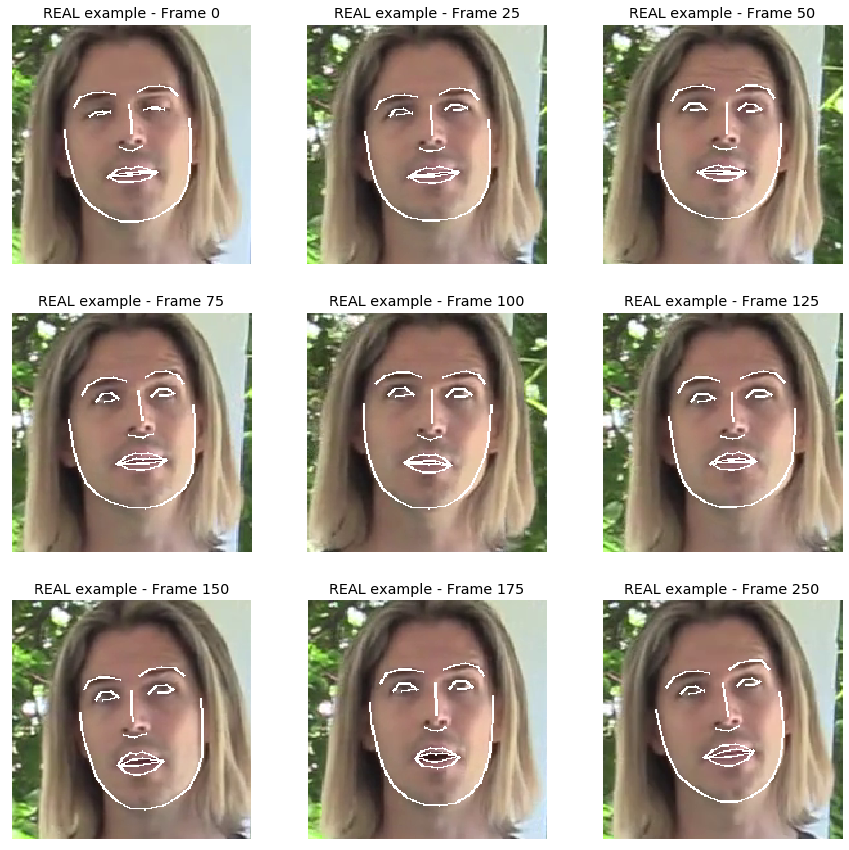

In [16]:
fn = 'ahqqqilsxt.mp4'
video_file = f'/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data/train_sample_videos/{fn}'

cap = cv.VideoCapture(video_file)

frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frames.append(frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()

print('The number of frames saved: ', len(frames))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = np.array(axes)
axes = axes.reshape(-1)
ax_ix = 0
padding = 40
features = {}
for i in [0, 25, 50, 75, 100, 125, 150, 175, 250, 275]:
    frame = frames[i]  
    #fig, ax = plt.subplots(1,1, figsize=(5, 5))
    face_locations = face_recognition.face_locations(frame)
    if len(face_locations) == 0:
        print(f'Count find face in frame {i}')
        continue
    top, right, bottom, left = face_locations[0]
    frame_face = frame[top-padding:bottom+padding, left-padding:right+padding]
    face_landmarks_list = face_recognition.face_landmarks(frame_face)
    if len(face_landmarks_list) == 0:
        print(f'Could not identify face landmarks for frame {i}')
        continue
    face_landmarks = face_landmarks_list[0]
    pil_image = Image.fromarray(frame_face)
    d = ImageDraw.Draw(pil_image)
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=2, fill='white')
    landmark_face_array = np.array(pil_image)
    image = cv.cvtColor(landmark_face_array, cv.COLOR_BGR2RGB)
    axes[ax_ix].imshow(image)
    axes[ax_ix].grid(False)
    axes[ax_ix].set_title(f'REAL example - Frame {i}')
    axes[ax_ix].xaxis.set_visible(False)
    axes[ax_ix].yaxis.set_visible(False)
    ax_ix += 1
    if ax_ix >= len(axes):
        break
plt.grid(False)
plt.show()

### Extract features from videoes

In [78]:
# refer from: https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn/notebook
# define a function to make an image smaller in size so that to avoid OOM exception
def resize_to_square(im):
    old_size = im.shape[:2]                               # old_size is in (height, width) format,like (1080,1920)
    ratio = float(img_size)/max(old_size)                 
    new_size = tuple([int(x*ratio) for x in old_size])    
    # new_size should be in (width, height) format
    im = cv.resize(im, (new_size[1], new_size[0]))        # narrow the image in same ratio 
    delta_w = img_size - new_size[1]                      # delta_w = 256 - 256 =0
    delta_h = img_size - new_size[0]                      # delta_h = 256 - 144 =112
    top, bottom = delta_h//2, delta_h-(delta_h//2)        # top, bottom
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,value=color)
    return new_im

# use the function 'resize_to_square' and use keras.applications.densenet to preprocess the small image
def load_image(image):
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

def show_me_the_pic(im):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = np.array(axes)
    axes = axes.reshape(-1)
    ax_ix = 0
    axes[ax_ix].imshow(im)
    axes[ax_ix].grid(False)
    axes[ax_ix].set_title('show you the picture')
    axes[ax_ix].xaxis.set_visible(False)
    axes[ax_ix].yaxis.set_visible(False)
    plt.grid(False)
    plt.show()

In [71]:
# 1st,Extract features from one video, like "ahqqqilsxt.mp4"

# just pick 1~10 images from the video to extract.
fn = 'ahqqqilsxt.mp4'
video_file = f'/a/bear.cs.fiu.edu./disk/bear-b/users/hluo003/Downloads/data/train_sample_videos/{fn}'
img_size = 256
batch_size = 25
cap = cv.VideoCapture(video_file)
frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frames.append(frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()

### define the densenet121 model which will be used to extract features

In [83]:
# use GAP to get the features and then followed by AP to get only 4 features among lots of features.
# notice: here if you use load_image function to resize and process the image, you should choose Input as (256,256,3), otherwise choose(1080,1920,3)
# inp = Input((1080,1920,3))                                      #Tensor("input_2:0", shape=(None, 256, 256, 3), dtype=float32)
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, include_top = False)   #keras.engine.training.Model object at 0x7ff8c80327f0
x = backbone.output                                               #Tensor("relu_3/Relu:0", shape=(None, 8, 8, 1024), dtype=float32)
x = GlobalAveragePooling2D()(x)                                   #Tensor("global_average_pooling2d_5/Mean:0", shape=(None, 1024), dtype=float32)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)               #Tensor("lambda_11/ExpandDims:0", shape=(None, 1024, 1), dtype=float32)
x = AveragePooling1D(4)(x)                                        #Tensor("average_pooling1d_7/Squeeze:0", shape=(None, 256, 1), dtype=float32)
out = Lambda(lambda x: x[:,:,0])(x)                               #Tensor("lambda_16/strided_slice:0", shape=(None, 256), dtype=float32)
m = Model(inp,out)
print(m)

# keras.applications.densenet.DenseNet121：https://keras.io/applications/#densenet
# include_top: whether to include the fully-connected layer at the top of the network.
# input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

In [88]:
# pick 10 frames and then extract their features by keras
features = {}
frameset = [0, 25, 50, 75, 100, 125, 150, 175, 250, 275]
batch_images = np.zeros((len(frameset),256,256,3))     # get batches of images, image at size [1080,1920], 3 is 
for i,frame_id in enumerate(frameset):
    try:
        batch_images[i] = load_image(frames[frame_id])   #resize the image to equal height and width at [256,256]
#         batch_images[i] = frames[frame_id]
    except:
        pass
print(batch_images.shape)
batch_preds = m.predict(batch_images)
for i,frame_id in enumerate(frameset):
    features[frame_id] = batch_preds[i]

(10, 256, 256, 3)


In [89]:
# put the features into a dataframe, and then output to a CSV file for future use
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.to_csv('train_img_features.csv')
train_feats.shape

(10, 256)

In [90]:
train_feats.head(10)

0         1         2         3         4         5         6    \
0    0.003490  0.121060  0.035257  0.026744  0.091959  0.002665  0.008879   
25   0.003463  0.126769  0.035977  0.024592  0.088086  0.002518  0.009003   
50   0.003456  0.128159  0.037487  0.026529  0.088915  0.002520  0.009188   
75   0.003660  0.127986  0.034510  0.025037  0.083780  0.002548  0.009253   
100  0.003613  0.131284  0.033789  0.026166  0.093357  0.002591  0.009451   
125  0.003488  0.125496  0.037660  0.025224  0.093430  0.002643  0.009153   
150  0.003413  0.124347  0.037689  0.025760  0.095747  0.002646  0.008674   
175  0.003393  0.122167  0.035424  0.025689  0.090158  0.002645  0.008942   
250  0.003526  0.124949  0.036828  0.025786  0.086413  0.002598  0.009294   
275  0.003615  0.122975  0.038497  0.026249  0.088396  0.002619  0.009196   

          7         8         9    ...       246       247       248  \
0    0.004280  0.112175  0.024843  ...  1.056017  0.704633  0.474136   
25   0.004040  0.108852  0.023989  ...  1.198164  0.777027  0.382128   
50   0.004233  0.102987  0.024813  ...  1.171373  1.037805  0.720747   
75   0.003825  0.110572  0.023179  ...  1.173143  0.945913  0.386993   
100  0.004123  0.108295  0.023225  ...  1.200670  0.926898  0.510480   
125  0.004224  0.114146  0.023502  ...  1.255149  0.805347  0.378327   
150  0.004033  0.114315  0.023133  ...  1.191957  0.715069  0.351396   
175  0.004199  0.112216  0.023537  ...  1.090547  0.835826  0.494842   
250  0.003778  0.105468  0.024029  ...  1.133923  0.933347  0.498226   
275  0.004215  0.104860  0.023260  ...  1.154193  0.831721  0.598294   

          249       250       251       252       253       254       255  
0    1.309486  2.133283  0.504886  0.584063  0.577003  0.573611  0.436412  
25   1.348709  1.840165  0.423727  0.634003  0.525818  0.565275  0.378631  
50   1.255425  1.796322  0.491957  0.703155  0.814543  0.567664  0.334445  
75   1.445040  1.966594  0.624052  0.635619  0.534943  0.566902  0.365659  
100  1.236507  1.869561  0.528503  0.630747  0.545302  0.570524  0.451084  
125  1.383364  1.636897  0.541491  0.609032  0.508580  0.491505  0.396896  
150  1.425363  1.661990  0.470659  0.408257  0.544723  0.628358  0.380953  
175  1.259564  1.892115  0.522056  0.448101  0.694657  0.553442  0.345985  
250  1.410978  2.102104  0.601178  0.649096  0.643800  0.511590  0.384498  
275  1.267302  2.231967  0.489466  0.575815  0.591414  0.620976  0.436495  

[10 rows x 256 columns]

In [ ]:
# 2nd,Extract features from all example videoes

In [ ]:
# 3nd,Extract features from all training videoes